This notebook provides an example of the use of variational Bayesian estimation and inference.  The VB computations here are based on Kay Broderson's MATLAB demo at https://www.tnu.ethz.ch/de/software/tapas.html

I have contrived a simple example where we compute a one-sample t-test versus zero.

In [1]:
import numpy,scipy
import time
from numpy.linalg import inv
from scipy.special import digamma,gammaln
from numpy import log,pi,trace
from numpy.linalg import det
import matplotlib.pyplot as plt
from pymc3 import Model,glm,find_MAP,NUTS,sample,Metropolis,HalfCauchy,Normal

%matplotlib inline



Set up code to estimate using VB

In [5]:
# Create classes for prior and posterior

# %     a_0: shape parameter of the prior precision of coefficients
# %     b_0: rate  parameter of the prior precision of coefficients
# %     c_0: shape parameter of the prior noise precision
# %     d_0: rate  parameter of the prior noise precision

class Prior:
    def __init__(self,a_0=10,b_0=0.2,c_0=10,d_0=1):
        self.a_0=a_0
        self.b_0=b_0
        self.c_0=c_0
        self.d_0=d_0

class Posterior:
    def __init__(self,d,prior):
        self.mu_n=numpy.zeros((d,1))
        self.Lambda_n = numpy.eye(d)
        self.a_n      = prior.a_0
        self.b_n      = prior.b_0
        self.c_n      = prior.c_0
        self.d_n      = prior.d_0
        self.F        = -numpy.inf
        self.prior    = prior
        self.trace = []
        
# Returns the variational posterior q that maximizes the free energy.
def invert_model(y, X, prior,tolerance=10e-8,verbose=False):

    # Data shortcuts
    n,d = X.shape # observations x regressors

    # Initialize variational posterior
    q=Posterior(d,prior)
    q.F=free_energy(q,y,X,prior)

    # Variational algorithm
    nMaxIter = 30
    kX = X.T.dot(X)

    for i in range(nMaxIter):

        # (1) Update q(beta) - regression parameters
        q.Lambda_n = q.a_n/q.b_n + q.c_n/q.d_n * (X.T.dot(X))

        q.mu_n = q.c_n/q.d_n * numpy.linalg.inv(q.Lambda_n).dot(X.T.dot(y))

        # (2) Update q(alpha) - precision
        q.a_n = prior.a_0 + d/2
        q.b_n = prior.b_0 + 1/2 * (q.mu_n.T.dot(q.mu_n) + trace(inv(q.Lambda_n)));

        # (3) Update q(lambda)
        q.c_n = prior.c_0 + n/2
        pe = y - X.dot(q.mu_n)
        q.d_n = prior.d_0 + 0.5 * (pe.T.dot(pe) + trace(inv(q.Lambda_n).dot(kX))) ;

        # Compute free energy
        F_old = q.F;
        q.F = free_energy(q,y,X,prior);

        # Convergence?
        if (q.F - F_old) < tolerance:
            break
        if i == nMaxIter:
            print('tvblm: reached max iterations',i)
    if verbose:
        print('converged in %d iterations'%i)
    return q

# Computes the free energy of the model given the data.
def free_energy(q,y,X,prior):
    # Data shortcuts
    n,d = X.shape # observations x regressors

    # Expected log joint <ln p(y,beta,alpha,lambda)>_q
    J =(n/2*(digamma(q.c_n)-log(q.d_n)) - n/2*log(2*pi)
        - 0.5*q.c_n/q.d_n*(y.T.dot(y)) + q.c_n/q.d_n*(q.mu_n.T.dot(X.T.dot(y)))
        - 0.5*q.c_n/q.d_n*trace(X.T.dot(X) * (q.mu_n.dot(q.mu_n.T) + inv(q.Lambda_n)))
        - d/2*log(2*pi) + n/2*(digamma(q.a_n)-log(q.b_n))
        - 0.5*q.a_n/q.b_n * (q.mu_n.T.dot(q.mu_n) + trace(inv(q.Lambda_n)))
        + prior.a_0*log(prior.b_0) - gammaln(prior.a_0)
        + (prior.a_0-1)*(digamma(q.a_n)-log(q.b_n)) - prior.b_0*q.a_n/q.b_n
        + prior.c_0*log(prior.d_0) - gammaln(prior.c_0)
        + (prior.c_0-1)*(digamma(q.c_n)-log(q.d_n)) - prior.d_0*q.c_n/q.d_n)

    # Entropy H[q]
    H = (d/2*(1+log(2*pi)) + 1/2*log(det(inv(q.Lambda_n)))
      + q.a_n - log(q.b_n) + gammaln(q.a_n) + (1-q.a_n)*digamma(q.a_n)
      + q.c_n - log(q.d_n) + gammaln(q.c_n) + (1-q.c_n)*digamma(q.c_n))

    # Free energy
    F = J + H
    return(F)


Now create synthetic data with a specified mean and perform a one sample t-test using either the t-test function from scipy.stats or using VB estimation.

In [50]:
npts=64
std=1
nruns=1000

# one sample t test
X=numpy.ones((npts,1))
prior=Prior(a_0=10,c_0=10)
means=numpy.arange(0,0.501,0.1)
vb_siglevel=numpy.zeros(len(means))
t_siglevel=numpy.zeros(len(means))

t_time=0
vb_time=0

for j,mean in enumerate(means):
    vb_pvals=numpy.zeros(nruns)
    t_pvals=numpy.zeros(nruns)
    for i in range(nruns):
        y=numpy.random.randn(npts)*std+mean
        t=time.time()
        q=invert_model(y, X, prior,verbose=False)
        # q.Lambda_n is the estimated precision, so we turn it into a standard deviation
        vb_pvals[i]=scipy.stats.norm.cdf(0,q.mu_n,1/numpy.sqrt(q.Lambda_n))
        vb_time+=time.time()-t
        
        t=time.time()
        _,t_pvals[i]=scipy.stats.ttest_1samp(y,0)
        t_time+=time.time()-t

    vb_siglevel[j]=numpy.mean(vb_pvals<0.05)
    t_siglevel[j]=numpy.mean(t_pvals<0.05)

print('Total elapsed time for %d analyses (seconds):'%int(len(means)*nruns))
print('t-test: %0.2f'%t_time)
print('VB: %0.2f'%vb_time)

Total elapsed time for 6000 analyses (seconds):
t-test: 1.29
VB: 10.57


Now plot the error/power for the two approaches.  For the t-test, this is the proportion of statistically significant outcomes over the realizations (at p<0.05).  For the VB estimate, this is the proportion of tests for which zero falls below the 5%ile of the estimated posterior.  

False positive rate:
t-test: 0.0540
VB: 0.0350


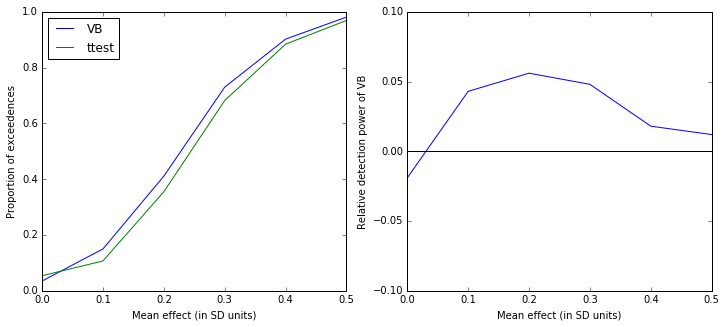

In [58]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(means,vb_siglevel)
plt.plot(means,t_siglevel)
plt.xlabel('Mean effect (in SD units)')
plt.ylabel('Proportion of exceedences')
plt.legend(['VB','ttest'],loc=2)

plt.subplot(1,2,2)
plt.plot(means,vb_siglevel-t_siglevel)
plt.ylim([-0.1,0.1])
plt.plot([means[0],means[-1]],[0,0],'k')
plt.xlabel('Mean effect (in SD units)')
plt.ylabel('Relative detection power of VB')
print('False positive rate:')
print('t-test: %0.4f'%t_siglevel[0])
print('VB: %0.4f'%vb_siglevel[0])


Play around with the prior values for precision of the coefficients - how do they affect the relative efficiency of VB versus the t-test?